In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl
from numpy.random import multivariate_normal as mvn, normal as normal
from scipy.optimize import minimize
from utils import StellarAndPlanetGP, StellarActivityGP, QuasiPeriodicKernel
import pandas as pd
from sklearn.preprocessing import StandardScaler
import corner

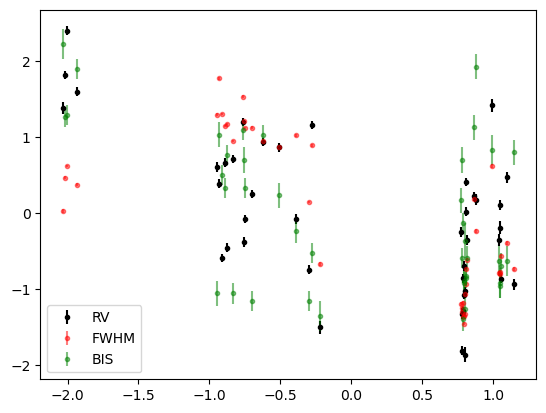

In [2]:
data = pd.read_csv(
    '../../data/ex2_RVs.txt',
    sep=',',
    header=None,
    names=['time', 'radial_velocity', 'radial_velocity_uncertainty', 'FWHM_CCF',
           'FWHM_CCF_uncertainty', 'BIS', 'BIS_uncertainty', 'instrument'],
    skiprows=8,
)

data = data[~data['instrument'].isin(['INST1'])]

time_scaler = StandardScaler()
rv_scaler = StandardScaler()
fwhm_scaler = StandardScaler()
bis_scaler = StandardScaler()
y_scalers = [rv_scaler, fwhm_scaler, bis_scaler]

time = data['time'].values
rv = data['radial_velocity'].values
rv_err = data['radial_velocity_uncertainty'].values
fwhm = data['FWHM_CCF'].values
fwhm_err = data['FWHM_CCF_uncertainty'].values
bis = data['BIS'].values
bis_err = data['BIS_uncertainty'].values

time = time_scaler.fit_transform(time.reshape(-1, 1)).ravel()
rv = rv_scaler.fit_transform(rv.reshape(-1, 1)).ravel()
rv_err = (rv_err / rv_scaler.scale_).ravel()
fwhm = fwhm_scaler.fit_transform(fwhm.reshape(-1, 1)).ravel()
fwhm_err = (fwhm_err / fwhm_scaler.scale_).ravel()
bis = bis_scaler.fit_transform(bis.reshape(-1, 1)).ravel()
bis_err = (bis_err / bis_scaler.scale_).ravel()


y = np.vstack([rv, fwhm, bis]).T
y_err = np.vstack([rv_err, fwhm_err, bis_err]).T

plt.errorbar(time, y[:, 0], yerr=y_err[:, 0], fmt='k.', label='RV')
plt.errorbar(time, y[:, 1], yerr=y_err[:, 1], fmt='r.', label='FWHM', alpha=0.5)
plt.errorbar(time, y[:, 2], yerr=y_err[:, 2], fmt='g.', label='BIS', alpha=0.5)
plt.legend()

In [3]:
def triple_plot(kernels, time, y, y_err, time_scaler, y_scalers):
    t_linspace = np.linspace(time.min(), time.max(), 1400)

    posteriors = []

    for i, kernel in enumerate(kernels):
        kernel.compute_kernel(time, time, y_err[:, i]).compute_loglikelihood(y[:, i])
        print(kernel.loglikelihood)
        mu_post, cov_post = kernel.compute_posterior(t_linspace)
        posteriors.append((mu_post, cov_post))

    # Plot the results
    plt.figure(figsize=(14, 14))
    
    titles = ['RV', 'FWHM', 'BIS']
    y_label = 'RV ($m s^{-1}$)'
    x_label = 'Time (BJD)'
    
    for i, (mu_post, cov_post) in enumerate(posteriors):
        std_post = np.sqrt(np.diag(cov_post))
        plt.subplot(3, 1, i+1)
    
        plt.errorbar(
            time_scaler.inverse_transform(time.reshape(-1, 1)).ravel(), 
            y_scalers[i].inverse_transform(y[:, i].reshape(-1, 1)).ravel(), 
            yerr=y_err[:, i] * y_scalers[i].scale_, 
            fmt='kx', label=f'{titles[i]} training data'
        )
    
        plt.plot(
            time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
            y_scalers[i].inverse_transform(mu_post.reshape(-1, 1)), 
            'b', label=f'GP Mean'
        )
    
        plt.fill_between(
            time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
            y_scalers[i].inverse_transform((mu_post - 2*std_post).reshape(-1, 1)).ravel(), 
            y_scalers[i].inverse_transform((mu_post + 2*std_post).reshape(-1, 1)).ravel(), 
            color='blue', alpha=0.2, label='Confidence interval (±2 std)'
        )
        
        plt.margins(x=0.01)
    
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.title(titles[i])

    plt.tight_layout()
    plt.show()
    
def residual_plot(kernel, time, rv, rv_err, time_scaler):
    kernel.compute_kernel(time, time, rv_err).compute_loglikelihood(rv)
    print(kernel.loglikelihood)
    mu_post, cov_post = kernel.compute_posterior(time)


    # Plot the results
    plt.figure(figsize=(6, 4))
    
    std_post = np.sqrt(np.diag(cov_post))
    residuals = rv - mu_post
    normalised_residuals = residuals / std_post
    
    plt.plot(
        time_scaler.inverse_transform(time.reshape(-1, 1)).ravel(),
        normalised_residuals,
        'o'
    )

    plt.margins(x=0.01)
    x_label = 'Time (BJD)'
    plt.xlabel('Time (BJD)')
    plt.ylabel('Normalised Residuals')

    plt.tight_layout()
    plt.show()
    

0.12207453583958126 [34.38877836]
-65.59295377792856
-8.988443977348044
-41.29951763789144


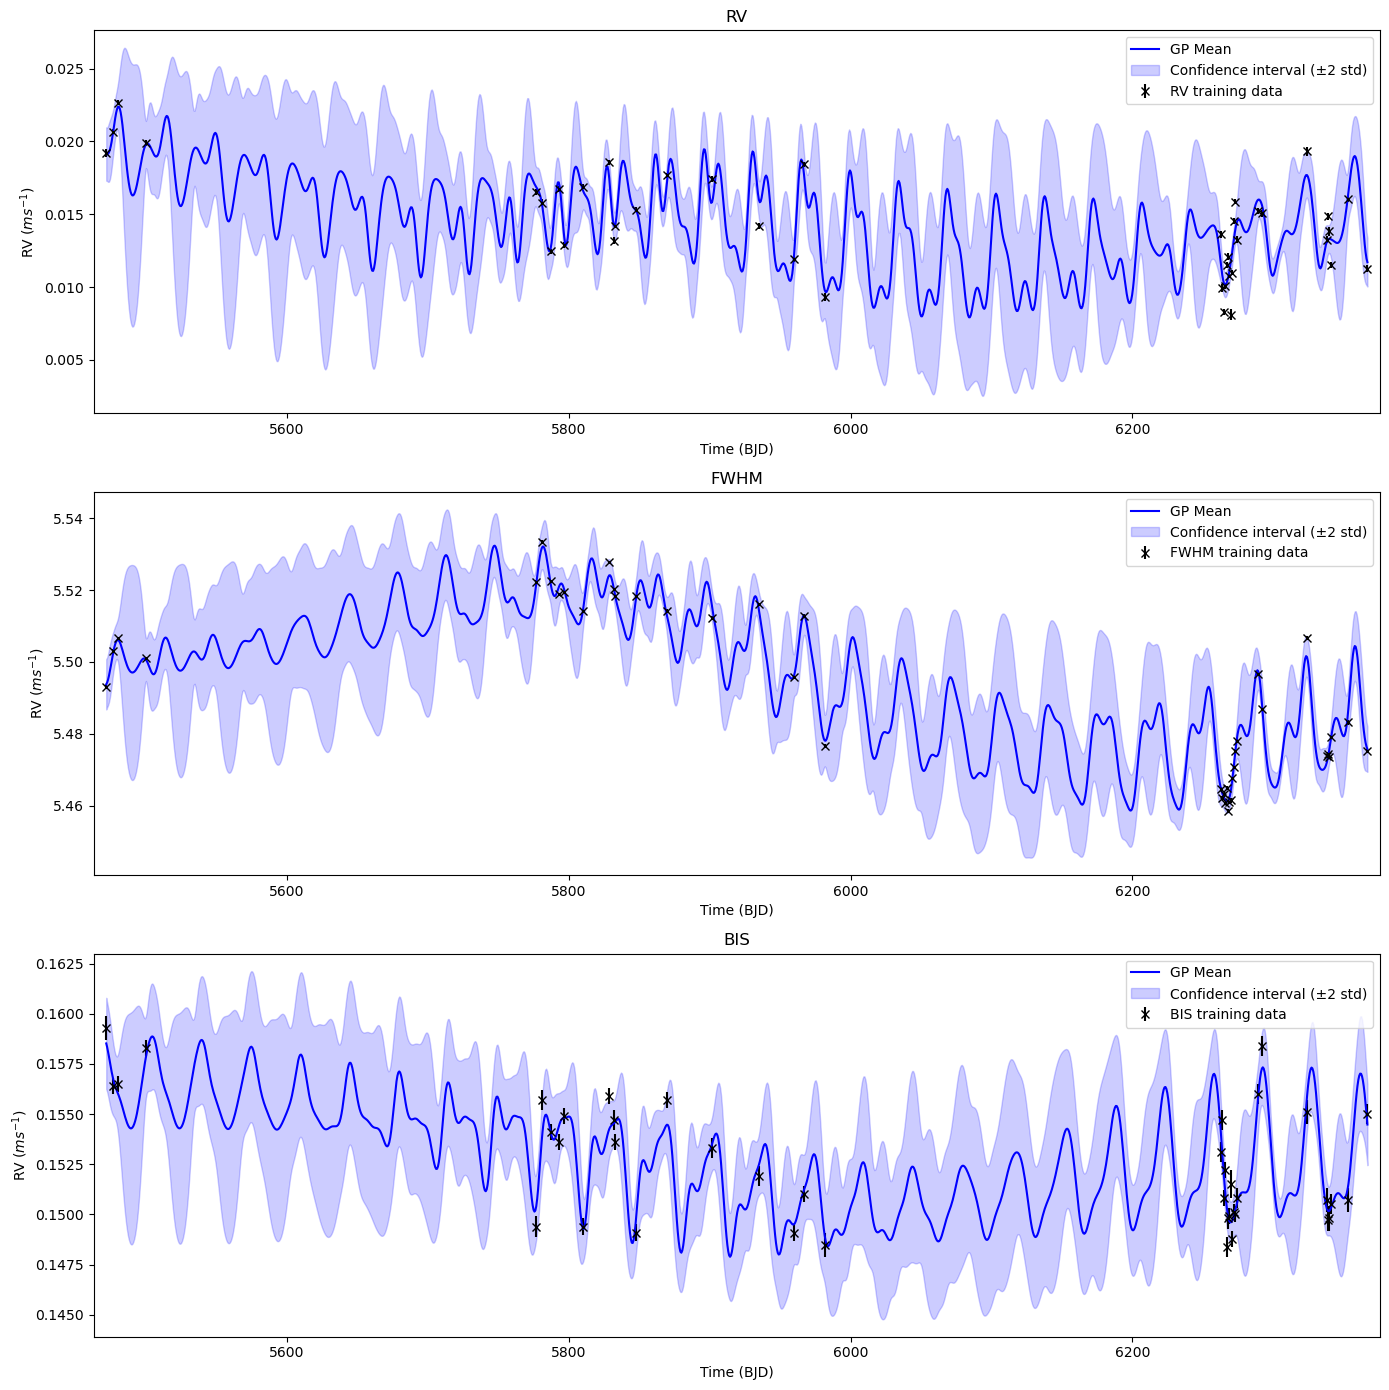

In [4]:
np.random.seed(42)
gp = StellarAndPlanetGP(time, y, y_err, num_planets=0)
result = gp.fit(
    bounds={'stellar_P': (21, 41) / time_scaler.scale_}
)
print(gp.model_params['stellar_P'], gp.model_params['stellar_P'] * time_scaler.scale_)
triple_plot(gp.kernels, time, y, y_err, time_scaler, y_scalers)

-65.59295377792856


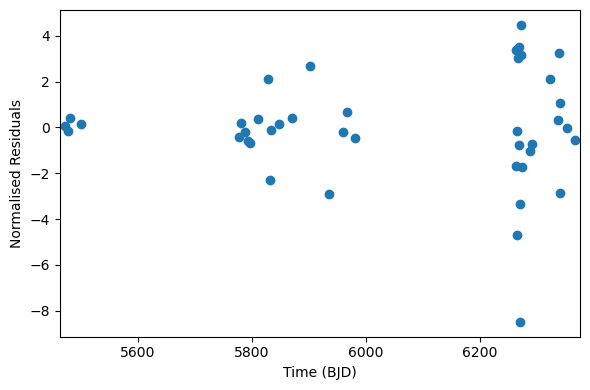

In [5]:
residual_plot(gp.kernels[0], time, rv, rv_err, time_scaler)

In [27]:
sampler = gp.run_mcmc(
    nwalkers=1000, niterations=1000, 
    bounds={'stellar_P': (21, 41) / time_scaler.scale_}, 
    initial_theta={key: value for key, value in zip(gp.model_params.keys(), result.x)}
)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/adnansiddiquei/miniconda3/envs/as3438_exo/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [02:23<00:00,  6.99it/s]


In [ ]:
# Extract the samples
samples = sampler.get_chain(discard=200, thin=10, flat=True)
samples[:, 0] = rv_scaler.inverse_transform(samples[:, 0].reshape(-1, 1)).ravel()
samples[:, 1] = fwhm_scaler.inverse_transform(samples[:, 1].reshape(-1, 1)).ravel()
samples[:, 2] = bis_scaler.inverse_transform(samples[:, 2].reshape(-1, 1)).ravel()
samples[:, 3] = samples[:, 3] * time_scaler.scale_
samples[:, 4] = samples[:, 4] * time_scaler.scale_
samples[:, 5] = samples[:, 5] * time_scaler.scale_

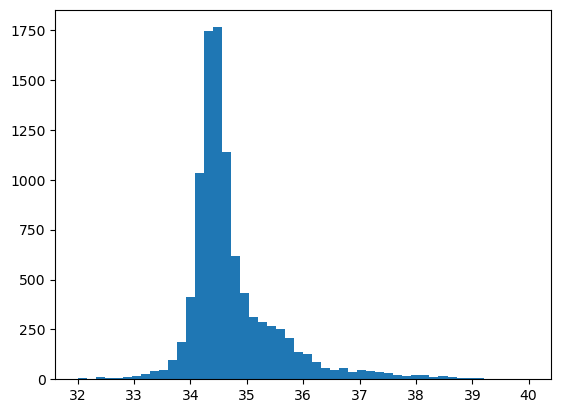

In [53]:
plt.hist(samples[:, 3], bins=50, range=(32, 40))
plt.show()

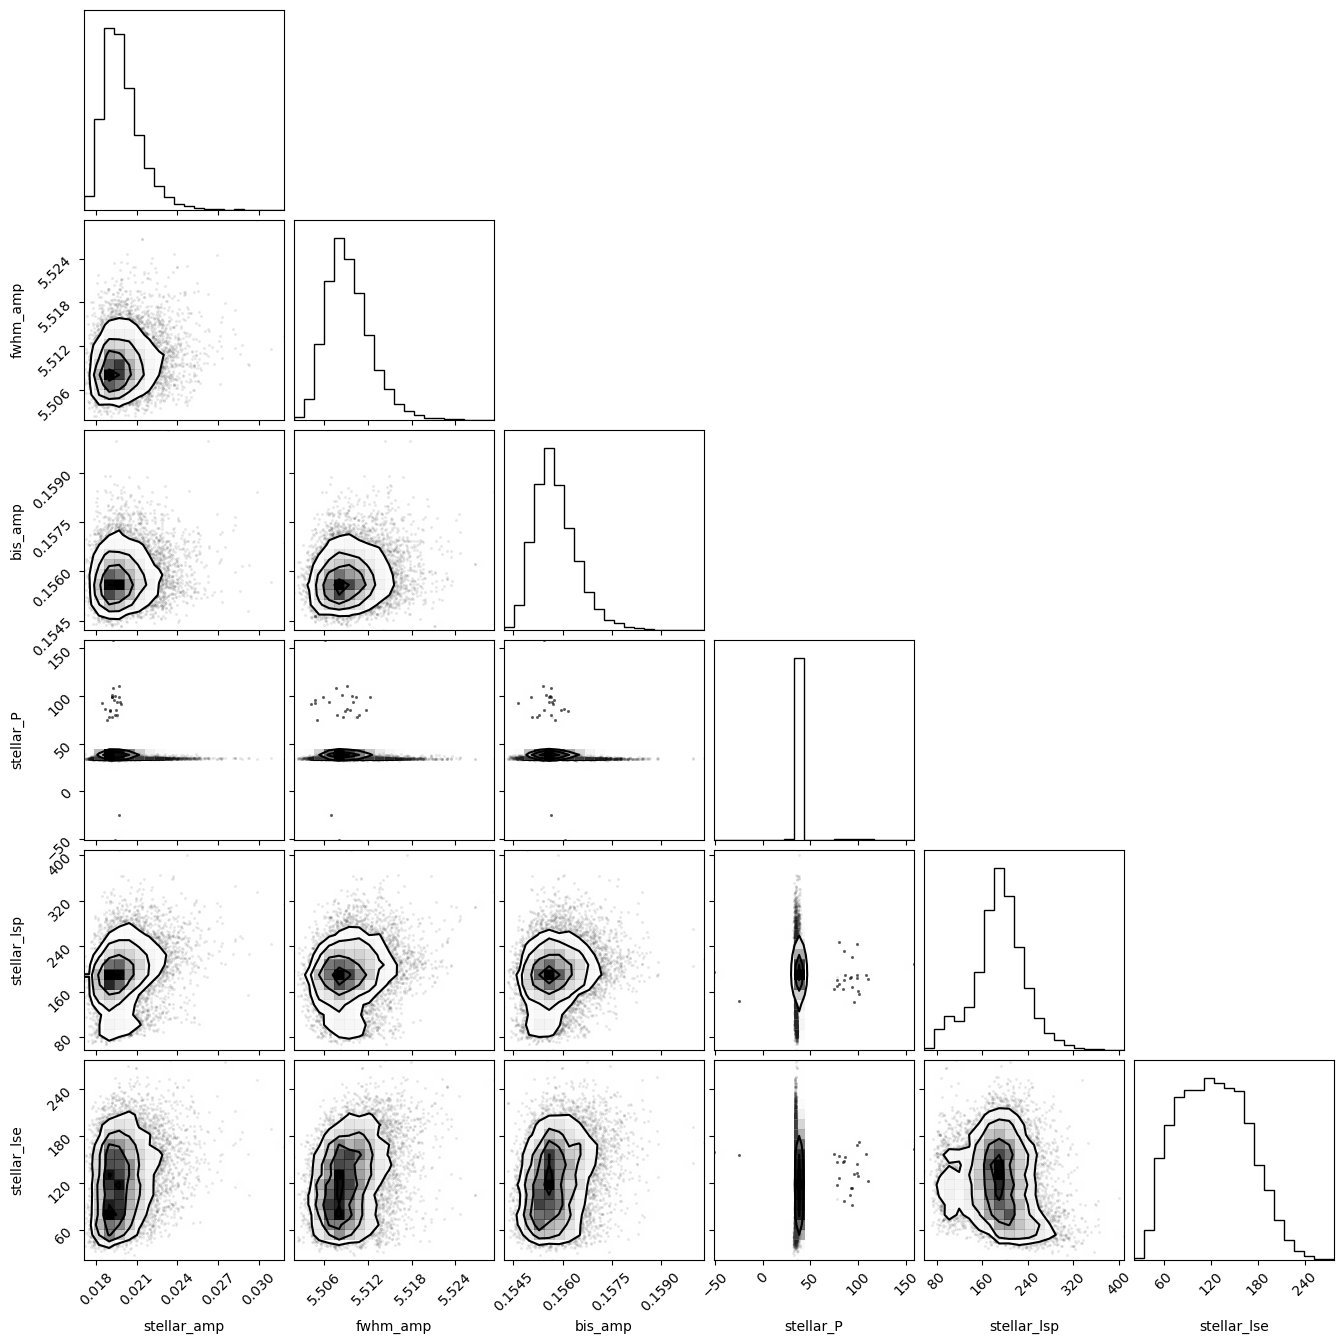

In [51]:
labels = gp.params_keys
figure = corner.corner(samples, labels=labels, truths=None, ranges=[
    None, None, None, (100, 101), None, None
])
# axes = np.array(figure.axes).reshape((6, 6))
# axes[3, 3].set_xlim(0, 50)
plt.show()

[34.72486004] [432.48084755]
-61.44683040125079
-7.874025492992452
-39.47379728508744


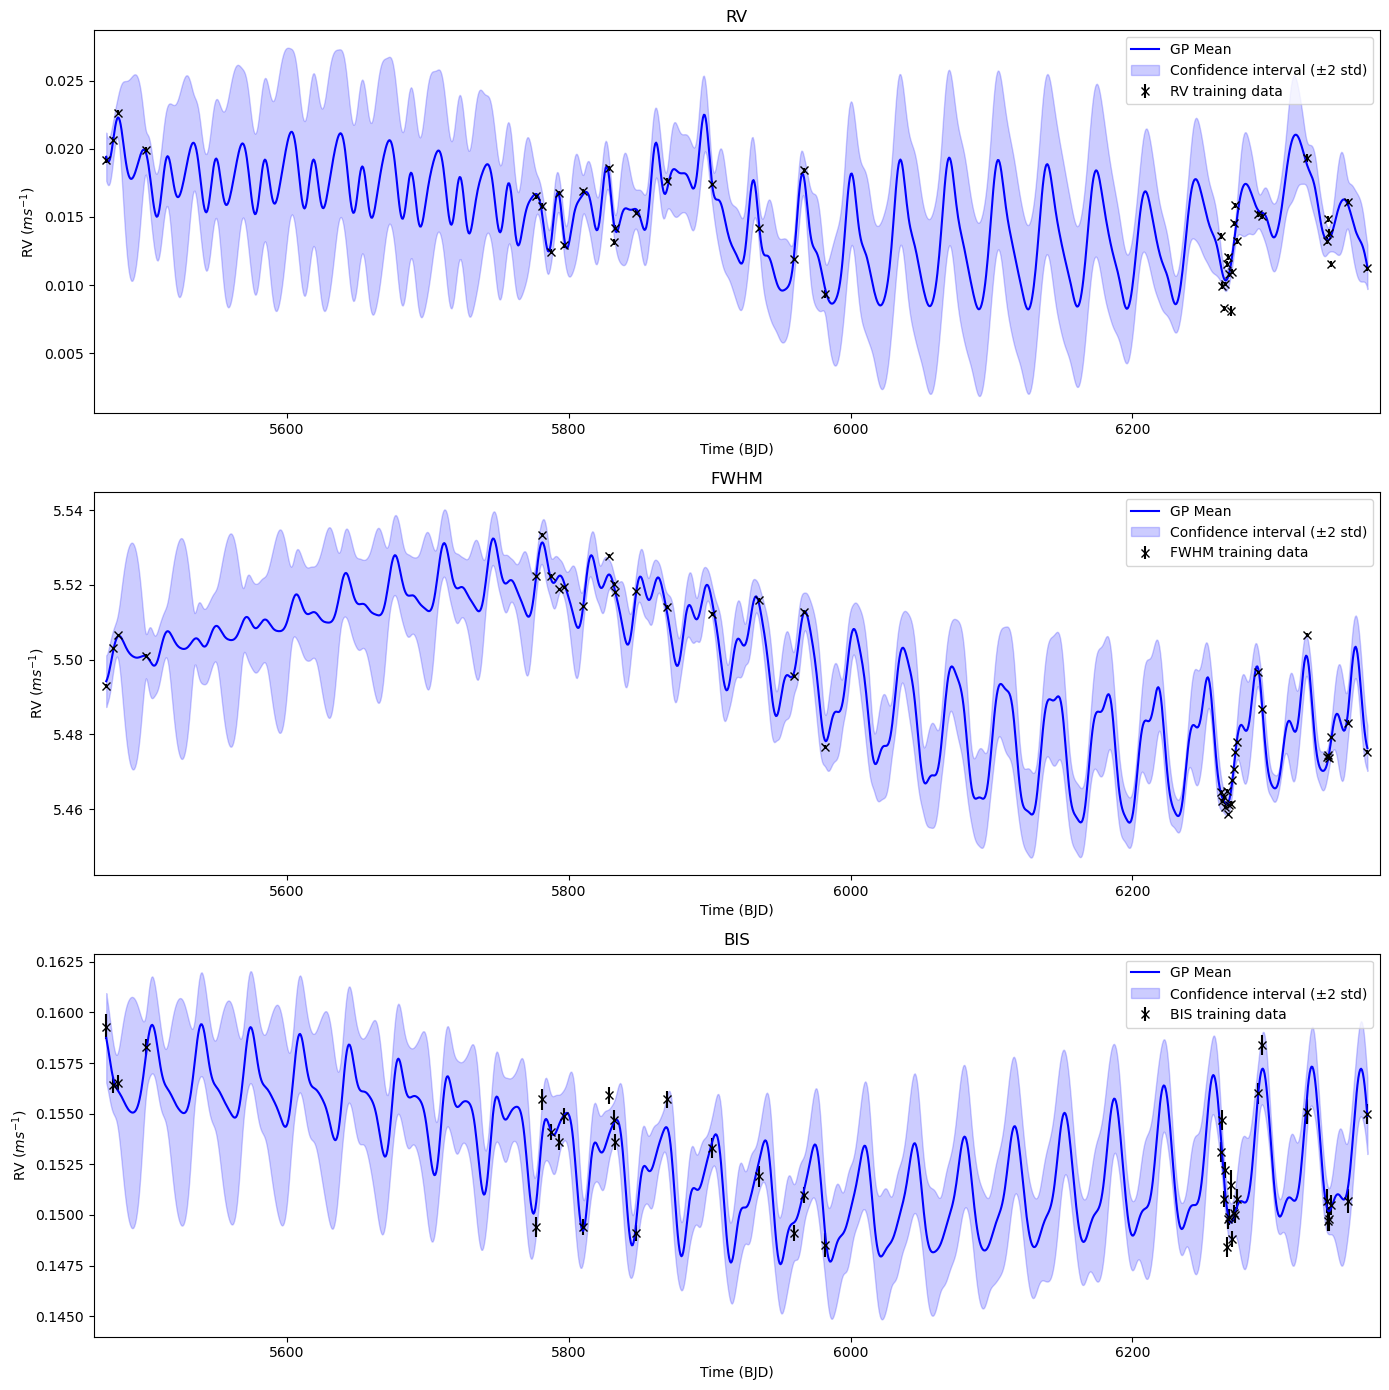

In [80]:
np.random.seed(42)
gp = StellarAndPlanetGP(time, y, y_err, num_planets=1)
result = gp.fit(
    bounds={'stellar_P': (21, 41) / time_scaler.scale_, 'p1_lsp': (1e-5, None)}
)
print(
    gp.model_params['stellar_P'] * time_scaler.scale_,
    gp.model_params['p1_P'] * time_scaler.scale_,
)
triple_plot(gp.kernels, time, y, y_err, time_scaler, y_scalers)

-61.44683040125079


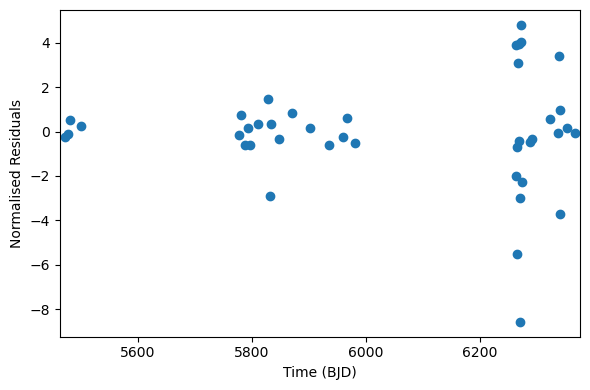

In [81]:
residual_plot(gp.kernels[0], time, rv, rv_err, time_scaler)

In [82]:
gp.model_params

{'stellar_amp': 1.2576414387502863,
 'fwhm_amp': 0.7729053571530025,
 'bis_amp': 1.084728680958066,
 'stellar_P': 0.12326757081723634,
 'stellar_lsp': 0.7624448325934828,
 'stellar_lse': 0.7226393233290596,
 'p1_amp': 0.702679569641256,
 'p1_P': 1.535236238058039,
 'p1_lsp': 0.24051263223840186}

In [84]:
sampler = gp.run_mcmc(
    nwalkers=1000, niterations=1000, 
    bounds={'stellar_P': (21, 41) / time_scaler.scale_, 'p1_lsp': (1e-5, None)},
    initial_theta={key: value for key, value in zip(gp.model_params.keys(), result.x)}
)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/adnansiddiquei/miniconda3/envs/as3438_exo/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]


In [87]:
# Extract the samples
samples = sampler.get_chain(discard=200, thin=10, flat=True)
samples[:, 0] = rv_scaler.inverse_transform(samples[:, 0].reshape(-1, 1)).ravel()
samples[:, 1] = fwhm_scaler.inverse_transform(samples[:, 1].reshape(-1, 1)).ravel()
samples[:, 2] = bis_scaler.inverse_transform(samples[:, 2].reshape(-1, 1)).ravel()
samples[:, 3] = samples[:, 3] * time_scaler.scale_
samples[:, 4] = samples[:, 4] * time_scaler.scale_
samples[:, 5] = samples[:, 5] * time_scaler.scale_
samples[:, 6] = rv_scaler.inverse_transform(samples[:, 6].reshape(-1, 1)).ravel()
samples[:, 7] = samples[:, 7] * time_scaler.scale_
samples[:, 8] = samples[:, 8] * time_scaler.scale_

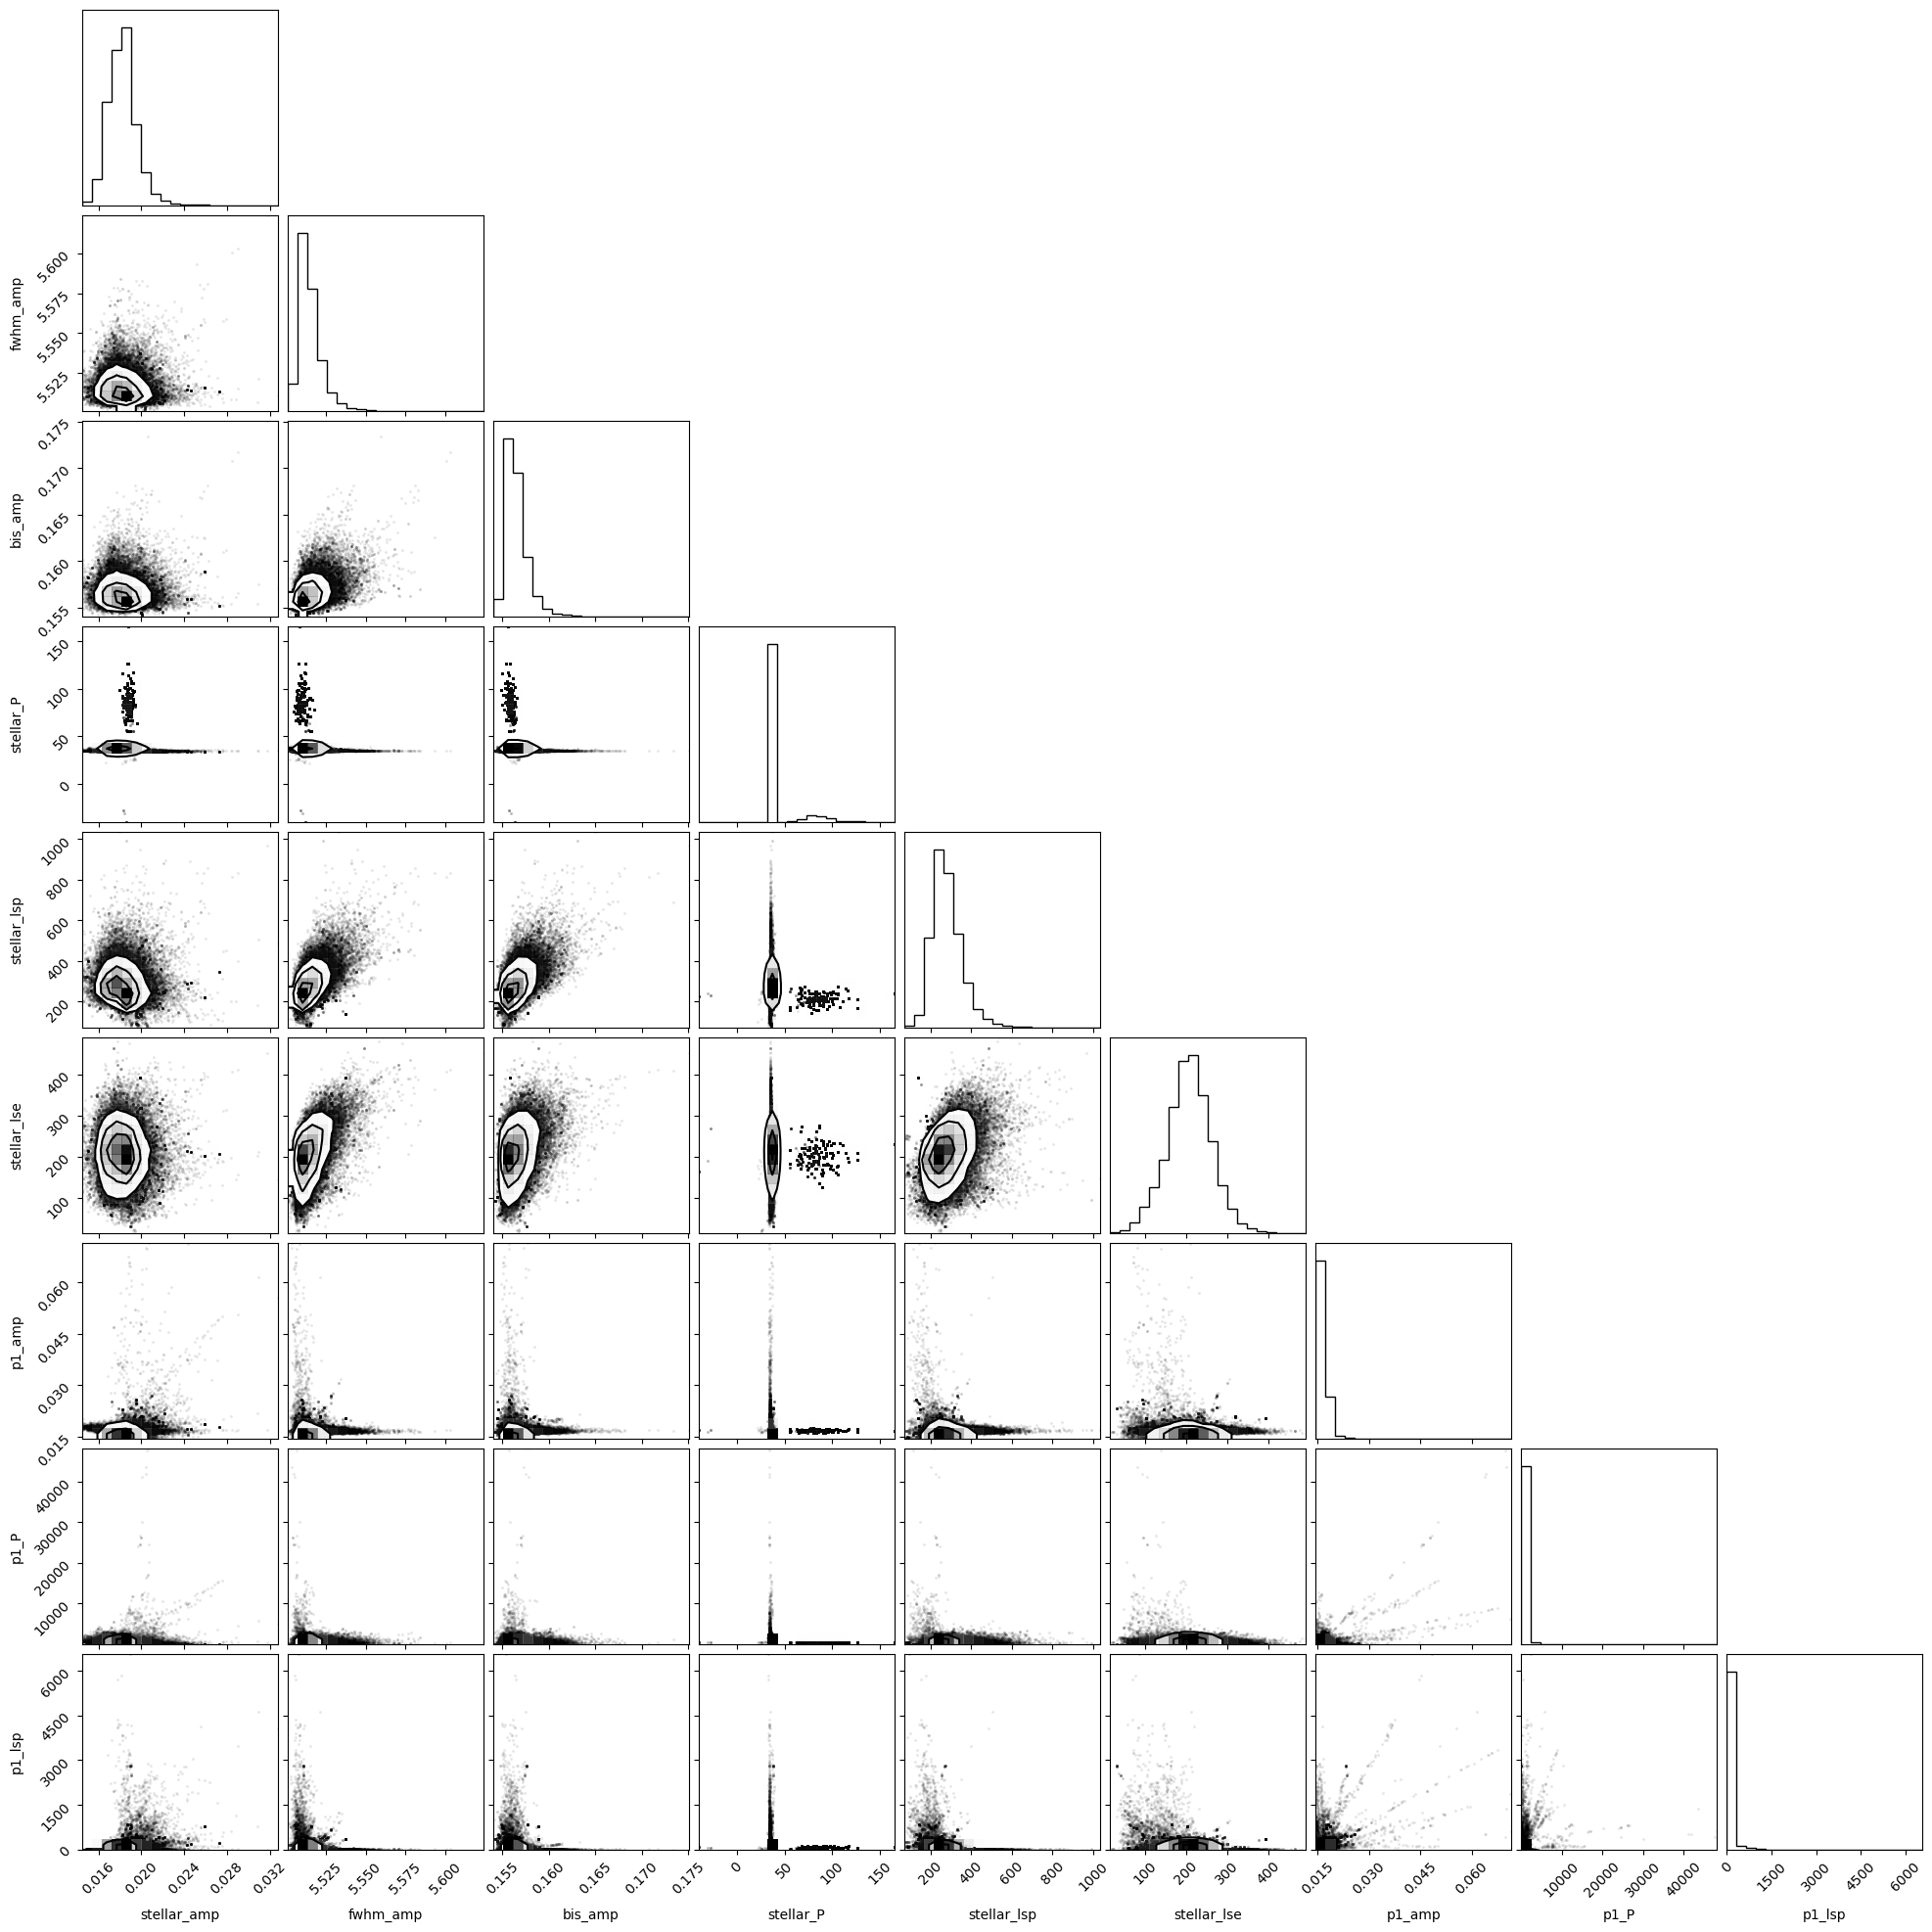

In [88]:
labels = gp.params_keys
figure = corner.corner(samples, labels=labels, truths=None, ranges=[
    None, None, None, (100, 101), None, None
])
# axes = np.array(figure.axes).reshape((6, 6))
# axes[3, 3].set_xlim(0, 50)
plt.show()

[35.01572862] [272.32122012] [419.24316833]
-42.29095516696552
-8.019341276492323
-38.62096131243936


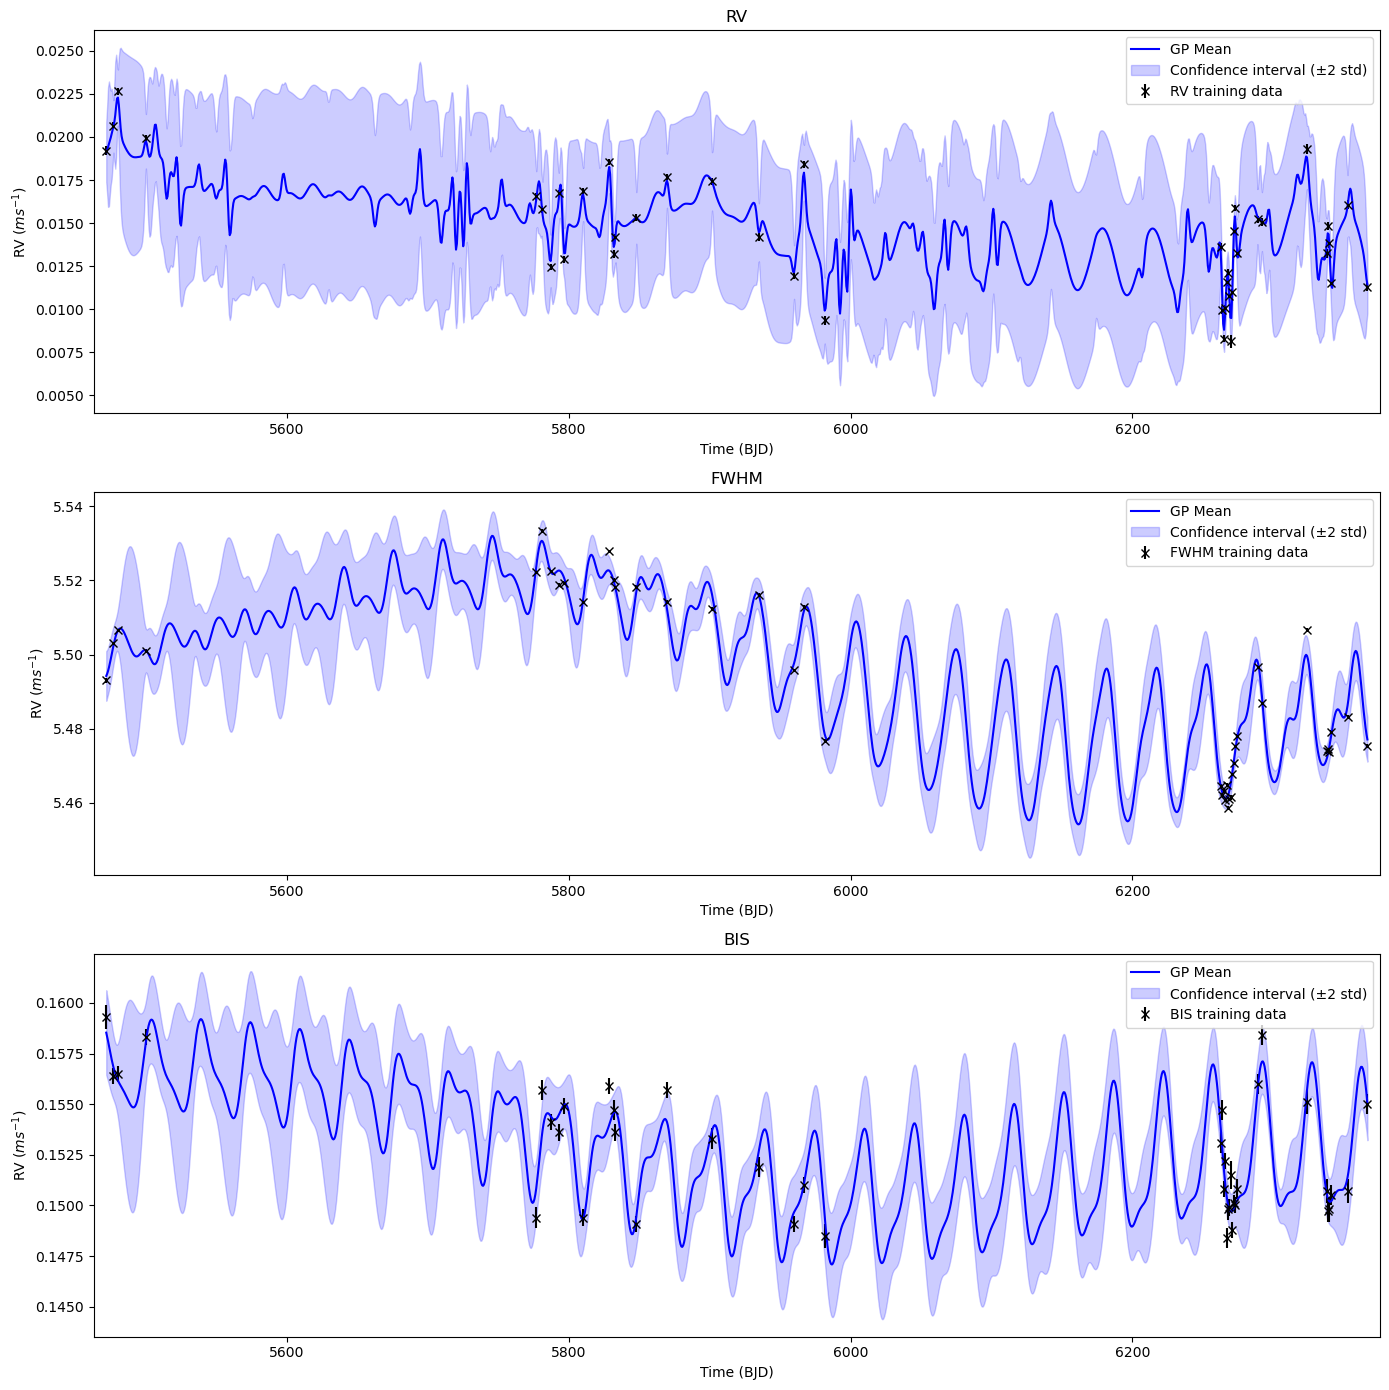

In [60]:
np.random.seed(44)
gp = StellarAndPlanetGP(time, y, y_err, num_planets=2)
gp.fit(
    bounds={'stellar_P': (21, 41) / time_scaler.scale_}
)
print(
    gp.model_params['stellar_P'] * time_scaler.scale_,
    gp.model_params['p1_P'] * time_scaler.scale_,
    gp.model_params['p2_P'] * time_scaler.scale_,
)
triple_plot(gp.kernels, time, y, y_err, time_scaler, y_scalers)

-42.58039421446922


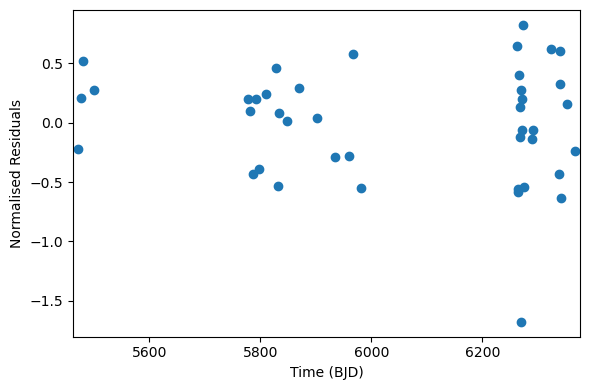

In [53]:
residual_plot(gp.kernels[0], time, rv, rv_err, time_scaler)